In [20]:
import os
import numpy as np
import glob
import pickle
import seaborn as sns
import matplotlib.ticker as ticker

import utils

In [2]:
# indicate a file to analyze
fname = 'VJ_OFCVTA_7_260_D6'
fdir = r'C:\2pData\Vijay data\VJ_OFCVTA_7_D8_trained'
flag_npil_corr = 0

# set the sampling rate
fs = 5

if flag_npil_corr == 1:
    signals_fpath = os.path.join(fdir, "{}_neuropil_corrected_signals*".format(fname))
    
elif flag_npil_corr == 0:
    signals_fpath = os.path.join(fdir, "*_extractedsignals*")

save_path = os.path.join(fdir, 'event_rel_analysis_' + fname)

utils.check_exist_dir(save_path) # make the save directory

In [68]:
# trial windowing 
trial_start_end_sec = np.array([-5, 10]) # trial windowing in seconds relative to ttl-onset/trial-onset
baseline_start_end_sec = np.array([-1, -0.1])

trial_win_samp = trial_start_end_sec*fs # turn trial start/end times to samples
baseline_win_samp = baseline_start_end_sec*fs

num_samples_trial = len( np.arange(trial_win_samp[0], trial_win_samp[1]) )
tvec = np.linspace(trial_start_end_sec[0], trial_start_end_sec[1], num_samples_trial+1)

In [69]:
# load time-series data
glob_signal_files = glob.glob(signals_fpath)
if len(glob_signal_files) == 1:
    signals = np.squeeze(np.load(glob_signal_files[0]))
else:
    print('Warning: No or multiple signal files detected; using first detected file')

num_rois = signals.shape[0]
    
#load behavioral data and trial info
try:
    glob_frame_files = glob.glob(os.path.join(fdir, "framenumberforevents_{}_*".format(fname))) # look for a file in specified directory
    event_frames = pickle.load( open( glob_frame_files[0], "rb" ) ) # latin1 b/c original pickle made in python 2

except:
    print('Cannot find behavioral data file or file path is incorrect; utils.extract_trial_data will throw error.')

In [70]:
conditions = event_frames.keys()
conditions

['licks',
 'plus_unrewarded',
 'minus_unrewarded',
 'minus_rewarded',
 'plus',
 'plus_rewarded',
 'minus']

In [176]:
data_dict = utils.extract_trial_data(signals, trial_win_samp[0], trial_win_samp[1], event_frames, conditions)

[0.7926429, 2.1161098]

In [ ]:
# for trial_avg data, get min/max across conditions
clims = [ np.nanmin( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ), 
        np.nanmax( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ) ]
clims

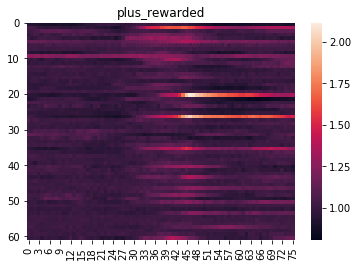

In [157]:


cond = 'plus_rewarded'

trial_avg = np.mean(data_dict[cond]['data'], axis = 0) # data dimensions are trials x roi x samples

ax = sns.heatmap(trial_avg)
ax.set_title(cond)
# ax.set_xticks(range(data_dict['plus_rewarded']['num_samples']))
# ax.set_xticklabels(tvec);

# ax.xaxis.set_major_locator(ticker.AutoLocator())
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

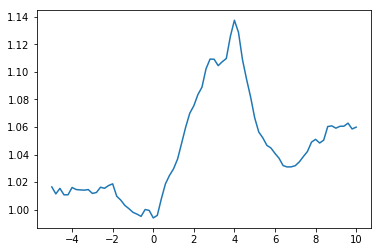

In [78]:
roi_trial_avg = np.mean(data_dict['plus_rewarded']['data'], axis = (0, 1))

sns.lineplot(tvec, roi_trial_avg)

In [ ]:
for cond in conditions:
    
    data_dict[cond]['data']
    
    
    

In [ ]:
event_frames = {}
event_frames['slm_stim'] = np.array([300.])

with open(r'D:\20200410_gcamp_chrmine\vj_ofc_imageactivate_01_300_stim-013\framenumberforevents_vj_ofc_imageactivate_01_300_stim-013.pickle', 'wb') as handle:
    pickle.dump(event_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)